# FINM 34700 Quantitative Trading Strartegy

Homework-3 Submitted by Vidhan Ajmera\
Email: vidhanajmera@uchicago.edu

# Financial Ratio Analysis: Quantile Strategies

## Sections
1. Objectives
2. Helper Functions
3. Data Import and cleaning
4. Financial Ratio Analysis
4. Trading Algorithm and Sensitivities
5. Conclusion

# 1. Objective

In this assignment, we look at financial accounting ratios as an approximation of quantamental models.

A <b>Quantamental model</b> is a type of investment strategy that combines the use of quantitative analysis and fundamental analysis. It uses both of these approaches in order to make investment decisions. The quantitative aspect of the model is used to identify potential investments, and the fundamental aspect is used to confirm the validity of the investment and to determine the appropriate level of risk. 
Quantamental modeling is an emerging trend in the industry, which is becoming more prevalent in the investment management industry as it allows investors to make more informed decisions by taking into account both quantitative and fundamental factors.
    
We start with collecting information on company fundamentals using <b>'Zacks Fundamentals Collection'</b> available on NasdaqDataLink platform. We also collect data on daily close prices and LIBOR rates from QUOTEMEDIA and FRED data providers.

# 2. Helper Functions

This section includes the import of relevant libraries and defining the functions for fetching, generating, plotting and analyzing the spreads.\
I have leveraged caching for storing the data fetched from Nasdaq Data Link.

In [1473]:
import os
import random
import numpy as np
import pandas as pd
import nasdaqdatalink
import scipy.stats as ss
import seaborn as sns
from functools import lru_cache
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import datetime
import pandas_datareader as pdr
import warnings
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]
warnings.filterwarnings('ignore')

In [588]:
 # Caching the function output
@lru_cache(maxsize=1600)
def get_EOD_data(sec):
    # Get one security (sec)'s data from Nasdaq Datalink using nasdaqdatalink.get_table    
    data =  nasdaqdatalink.get_table('QUOTEMEDIA/PRICES', date = { 'gte': '2015-01-01', 'lte': '2022-01-31'}, ticker = sec, qopts={"columns":['ticker','date','adj_close']})
    return data

In [1428]:
def trade_execution(net_percent_exposure, zscore, quantile, buffer = None):
    
    '''Builds a monthly quantile trading strategy based on:    
    1. net_percent_exposure( percentage of gross capital to be invested in strategy)
    2. z-scores (Standardized Financial Factors that form the basis for going long/short on tickers)
    3. quantile (percentage of stocks to go long or short in one trade) 
    4. Buffer-window (window for reducing the impact of changes in long/short stocks)'''
    
    track=tracker.copy()
    commited_capital = 1e8 #$100 million    
    n = int(round(len(df_final.loc[track.loc[0,'EnterDate']])*quantile,0))
    if buffer is None:
        h = n
    else:
        h = int(round(len(df_final.loc[track.loc[0,'EnterDate']])*buffer,0))
    long, short, longHold, shortHold = [], [], [], []
    trades, holdCount = 0, 0
    for idx in track.index:
        if idx==0:
            track.loc[idx,'StartCapital'] = commited_capital
        else:
            track.loc[idx,'StartCapital'] = track.loc[idx-1,'EndCapital']
        enterDay = df_final.loc[track.loc[idx,'EnterDate']]
        exitDay = df_final.loc[track.loc[idx,'ExitDate']]
        track.loc[idx,'ShortPos'] = -track.loc[idx,'StartCapital']*net_percent_exposure/2
        track.loc[idx,'LongPos'] = track.loc[idx,'StartCapital']*net_percent_exposure/2
        start = track.loc[idx,'EnterDate']
        finish = track.loc[idx,'ExitDate']
        repo = track.loc[idx,'RepoRate']
        track.loc[idx,'RepoCash'] = -(finish - start).days/365 * repo * track.loc[idx,'ShortPos']/100 
        ranks = list(enterDay.sort_values(by = zscore)['ticker'])
        shortHoldCandidate = ranks[:h]
        if h == 0:
            longHoldCandidate = []
        else:
            longHoldCandidate = ranks[-h:]
        shortHold = list(set(short) & set(shortHoldCandidate))        
        longHold = list(set(long) & set(longHoldCandidate))      
        short = ranks[:n-len(shortHold)] + shortHold        
        if n == len(longHold):
            long = longHold
        else:
            long = ranks[-n+len(longHold):] + longHold
        trades += 2*(len(short) + len(long))
        holdCount += 2*(len(shortHold) + len(longHold))
        x = len(short)
        y= len(long)
        shortAllocation = [1/x for _ in range(x)]
        longAllocation = [1/y for _ in range(y)]        
        shortPnL = 0
        for i,t in enumerate(short):
            shortPrice = enterDay[enterDay['ticker'] == t]['ADJ_CLOSE'][0]
            shortShares = track.loc[idx,'ShortPos'] * shortAllocation[i]/shortPrice  
            exitPrice = exitDay[exitDay['ticker'] == t]['ADJ_CLOSE'][0]
            exitPnL = shortShares*(exitPrice - shortPrice)
            shortPnL += exitPnL             
        longPnL = 0
        for i,t in enumerate(long):
            longPrice = enterDay[enterDay['ticker'] == t]['ADJ_CLOSE'][0]
            longShares = track.loc[idx,'LongPos'] * longAllocation[i]/longPrice
            exitPrice = exitDay[exitDay['ticker'] == t]['ADJ_CLOSE'][0]
            exitPnL = longShares*(exitPrice - longPrice)
            longPnL += exitPnL
        track.loc[idx,'ShortPnL'] = shortPnL
        track.loc[idx,'LongPnL'] = longPnL    
        track.loc[idx,'MonthPnL'] = shortPnL + longPnL + track.loc[idx,'RepoCash']
        track.loc[idx,'EndCapital'] = commited_capital + track.loc[idx,'MonthPnL']
        capital = track.loc[idx,'EndCapital']
    track['CumPnL'] = track['MonthPnL'].cumsum()    
    return track,trades - holdCount

# 3. Data Importing and Cleaning

<b> 3.1 Data Import from NasdaqDataLink ZFB database, 6 different tables</b> 

In [4]:
nasdaqdatalink.ApiConfig.api_key = 'Your_Api_Key'

In [5]:
start='2014-09-01'
end='2022-01-31'
os.makedirs('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata', exist_ok=True)

In [6]:
'''
Extracting data from Fundamentals Condensed (ZACKS/FC).
This table contains over 200 fundamental indicators for 
over19,500 companies including over 10,000 delisted stocks
'''
try:
    df_fc=pd.read_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_fc.csv')
except:
    df_fc = nasdaqdatalink.get_table('ZACKS/FC',per_end_date = {'gte': start, 'lte': end}\
                                     ,qopts = { 'columns': [ 'ticker', 'per_end_date','per_type','exchange',\
                                        'currency_code','zacks_sector_code','basic_net_eps','diluted_net_eps',\
                                            'tot_lterm_debt','net_lterm_debt','filing_date']}, paginate = True)
  
    df_fc.to_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_fc.csv')

In [7]:
 '''
Extracting data from Fundamentals Ratios (ZACKS/FR).
This table contains 26 fundamental ratios for over 19,500
companies, including over 10,000 delisted stocks.
'''
try:
    df_fr=pd.read_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_fr.csv')
except:
    df_fr = nasdaqdatalink.get_table('ZACKS/FR',per_end_date = {'gte': start, 'lte': end}\
                                     ,qopts = { 'columns': [ 'ticker', 'per_type','per_end_date','exchange',\
                                        'currency_code','tot_debt_tot_equity', 'ret_invst']}, paginate = True)  
    df_fr.to_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_fr.csv')

In [8]:
 '''
Extracting data from Shares out supplement (ZACKS/SHRS).
This table contains supplementary information to Zacks
fundamentals, with updated values for common shares 
outstanding and average diluted shares outstanding
'''
try:
    df_shrs=pd.read_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_shrs.csv')  
except:
    df_shrs=nasdaqdatalink.get_table('ZACKS/SHRS',per_end_date = {'gte': start, 'lte': end}\
                                     ,qopts = { 'columns': ['ticker', 'per_type','per_end_date','shares_out']}, paginate = True)  
    df_shrs.to_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_shrs.csv')

In [9]:
 '''
Extracting data from Master table (ZACKS/MT).
This table contains descriptive information about all
tickers that are included in Zacks products.
'''
try:
    df_mt=pd.read_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_mt.csv') 
except:
    df_mt = nasdaqdatalink.get_table('ZACKS/MT',qopts = { 'columns': ['ticker','ticker_type','asset_type']}, paginate = True)
    df_mt.to_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_mt.csv')

In [10]:
 '''
Extracting data from Market Value supplement (ZACKS/MKTV).
This table contains supplementary information to Zacks 
fundamentals, with updated values for market capitalization
and enterprise value.
'''
try:
    df_mktv=pd.read_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_mktv.csv')   
except:
    df_mktv = nasdaqdatalink.get_table('ZACKS/MKTV',per_end_date = {'gte': start, 'lte': end},qopts = { 'columns': ['ticker', 'per_type','per_end_date','mkt_val']}, paginate = True)
    df_mktv.to_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_mktv.csv')

In [11]:
 '''
Extracting data from Historical Daily Maintenance (ZACKS/HDM).
This table offers historical daily corporate actions for over 
7,000 U.S. and Canadian listed companies.
'''
try:
    df_hdm=pd.read_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_hdm.csv')
except:
    df_hdm = nasdaqdatalink.get_table('ZACKS/HDM',qopts = { 'columns': ['ticker','action_type','status']}, paginate = True)  
    df_hdm.to_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/out_hdm.csv')

<b> 3.2 Merging daily adjusted close price with quarterly financial data </b>

In [1344]:
df_merged = df_fc.merge(df_fr,how='inner',left_on=['ticker', 'per_type','per_end_date'],right_on=['ticker', 'per_type','per_end_date'])

In [1345]:
df_merged=df_merged.merge(df_shrs,how='inner',left_on=['ticker', 'per_type','per_end_date'],right_on=['ticker', 'per_type','per_end_date'])

In [1346]:
df_merged=df_merged.merge(df_mktv,how='inner',left_on=['ticker', 'per_type','per_end_date'],right_on=['ticker', 'per_type','per_end_date'])

In [1347]:
df_merged=df_merged.merge(df_mt,how='inner',left_on=['ticker'],right_on=['ticker'])

In [1348]:
df_merged=df_merged.rename(columns={'exchange_x':'exchange','currency_code_x':'currency_code'})

<b>3.3 Filtering the financial data based on various criteria </b>

We start with close to 8300 stocks extracted from the ZFB database, and try to filter out the outliers using various filters.

In [1349]:
print(f"Number of unique tickers: {df_merged['ticker'].nunique()}")

Number of unique tickers: 8299


We are dealing with <b>common stocks </b> and we can filter out ETFs, American Depository Receipts(ADR's) and Canadian stocks.

In [1350]:
df_merged=df_merged[df_merged['asset_type']=='COM']
print(f"Number of unique tickers: {df_merged['ticker'].nunique()}")

Number of unique tickers: 5455


Next, we want to build our data based on <b> quarterly reports</b>, and not based on annual financial reports. So we filter out rows associated with annual reports

In [1351]:
df_merged=df_merged[df_merged['per_type']!='A']
print(f"Number of unique tickers: {df_merged['ticker'].nunique()}")

Number of unique tickers: 5455


We have almost cut 1/3rd of the stocks. As mentioned in the question, we do not want to include any<b> automotive, financial or insurance </b>company in our analysis. These sectors are highly sensitive to business cycle and state of the economy.

In [1352]:
df_merged=df_merged[df_merged['zacks_sector_code']!=5]
df_merged=df_merged[df_merged['zacks_sector_code']!=13]
#df_merged=df_merged[df_merged['zacks_sector_code']!='NaN']
print(f"Number of unique tickers: {df_merged['ticker'].nunique()}")

Number of unique tickers: 4346


To have a better comparision, we are considering stocks for which debt-to-market capitablization ratio is greater than 0.3.

In [1353]:
for i in list(df_merged.ticker.unique()):
    if df_merged[df_merged['ticker']==i].tot_debt_tot_equity.max()<0.15:
        df_merged=df_merged[df_merged['ticker']!=i]
print(f"Number of unique tickers: {df_merged['ticker'].nunique()}")

Number of unique tickers: 3673


To have a fesible calculation of the financial ratios, we consider <b>negative eps values as 0.001 </b>. Also we try to remove the NaN values from the dataframe.

In [1354]:
df_merged=df_merged[ df_merged['ret_invst']!='NaN']
df_merged=df_merged[ df_merged['basic_net_eps']!='NaN']
df_merged.loc[df_merged['basic_net_eps']<=0,'basic_net_eps']=0.001
df_merged=df_merged[ df_merged['diluted_net_eps']!='NaN']
df_merged.loc[df_merged['diluted_net_eps']<=0,'diluted_net_eps']=0.001
df_merged=df_merged[ df_merged['filing_date']!='NaN']
df_merged=df_merged[ df_merged['net_lterm_debt']!='NaN']
df_merged=df_merged[ df_merged['tot_debt_tot_equity']!='NaN']
print(f"Number of unique tickers: {df_merged['ticker'].nunique()}")

Number of unique tickers: 3673


In [1355]:
df_merged=df_merged.dropna()
print(f"Number of unique tickers: {df_merged['ticker'].nunique()}")

Number of unique tickers: 2312


We have to consider the stocks for which quarterly data is available for every quarter. This would help us in improving out ratio calculations.

In [1356]:
for j in df_merged['ticker'].unique():
    if len(df_merged[df_merged['ticker']==j].per_end_date.unique())<30:
        df_merged=df_merged[df_merged['ticker']!=j]
print(f"Number of unique tickers: {df_merged['ticker'].nunique()}")

Number of unique tickers: 489


We are also considering <b> exchange traded stocks </b>, specifically, traded on NASDAQ and NYSE.

In [1357]:
df_merged=df_merged[(df_merged['exchange']!='NYSE MKT (ex. AMEX)')]
df_merged=df_merged[(df_merged['exchange']!='NASDAQ Other OTC')]
print(f"Number of unique tickers: {df_merged['ticker'].nunique()}")

Number of unique tickers: 471


As we see, we have reduced our universe of stocks from 8300 to 900. Considering the limit to access data from Nasdaqdatalink, we consider a sample of size 200 from this reduced dataset to move forward with out calculation

<b>3.4 Fetching Daily Adjusted close & Merging with Financial Data</b>

In [1358]:
ticker_list=tuple(df_merged['ticker'].unique())

In [1359]:
# ticker_sample=random.sample(ticker_list, 200)
# if 'LLY' not in ticker_sample:
#     ticker_sample.pop()
#     ticker_sample.append('LLY')
# len(ticker_sample)

In [1360]:
ticker_sample=ticker_list

In [1361]:
try:
    df_daily_price=pd.read_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/daily.csv')
except:
    df_daily_price = nasdaqdatalink.get_table("QUOTEMEDIA/PRICES", date = { 'gte': '2014-09-29', 'lte': '2022-01-31'}, 
                                       ticker = ticker_sample, qopts={"columns":['ticker','date','adj_close']},
                                      paginate = True)  
    df_daily_price.to_csv('/Users/vidhanajmera/Desktop/Winter 2023/QTS/metadata/daily.csv')

After fetching daily adjusted close price, we filter out stocks for which data is missing. We move forward with stocks which have <b> no duplicates and price available for all trading days </b>

In [1362]:
df_daily_price.date=pd.to_datetime(df_daily_price.date)
df_merged.filing_date=pd.to_datetime(df_merged.filing_date)
df_merged.sort_values(by=['ticker', 'filing_date'],inplace=True)
df_daily_price.sort_values(by=['ticker', 'date'],inplace=True)
None

In [1363]:
for k in df_daily_price['ticker'].unique():
    if len(df_daily_price[df_daily_price['ticker']==k].date.unique())!=1849:
        df_daily_price=df_daily_price[df_daily_price['ticker']!=k]
print(f"Number of unique tickers: {df_daily_price['ticker'].nunique()}")

Number of unique tickers: 451


In [1364]:
df_combined = df_daily_price.merge(df_merged,how='left',left_on=['ticker','date'],right_on=['ticker','filing_date'])

df_combined=df_combined.fillna(method="ffill")


In [1365]:
df_combined=df_combined[df_combined['date']>'2015-01-01']

In [1366]:
df_combined = df_combined.merge(df_daily_price,how='left',left_on=['ticker','per_end_date'],right_on=['ticker','date']).fillna(method="ffill")

In [1367]:
cols=['ticker','per_end_date', 'date_y','date_x','adj_close_x','adj_close_y']
df_combined[cols].head(90)

,ticker,per_end_date,date_y,date_x,adj_close_x,adj_close_y
0,AAL,2014-09-30,2014-09-30,2015-01-02,51.072326,33.529232
1,AAL,2014-09-30,2014-09-30,2015-01-05,51.039169,33.529232
2,AAL,2014-09-30,2014-09-30,2015-01-06,50.248121,33.529232
3,AAL,2014-09-30,2014-09-30,2015-01-07,50.219700,33.529232
4,AAL,2014-09-30,2014-09-30,2015-01-08,50.835486,33.529232
...,...,...,...,...,...,...
85,AAL,2015-03-31,2015-03-31,2015-05-06,44.752484,50.104248
86,AAL,2015-03-31,2015-03-31,2015-05-07,46.669293,50.104248
87,AAL,2015-03-31,2015-03-31,2015-05-08,46.650267,50.104248
88,AAL,2015-03-31,2015-03-31,2015-05-11,47.225785,50.104248


In [1368]:
df_combined = df_combined.rename(columns={'date_x':'Date','adj_close_x':'ADJ_CLOSE','adj_close_y':'PERIOD_ADJ_CLOSE'})

# 4. Financial Ratio Analysis

<b> 4.1 Compute the Financial Ratios </b>

We have generated a combined dataframe for each of our 450+ stock tickers for each trading day from Jan 2015 to Jan 2022, with following columns:
1. Adjusted Closing Price 
2. Diluted Net EPS/Basic Net EPS
3. Net Long Term Debt/Total Long Term Debt
4. Debt to Equity, Return on Investment, Market Value

Now, we compute the three factors(DMCAP, PE, ROI) that can be derived from the following formula:\
1. Debt to Market Cap Ratio =  $\frac{\text{Total Debt to Total Equity(i) * close price(i)}}{\text{daily close price}}$ 
<br><br>
2. Price to Earnings Ratio = $\frac{\text{daily close price}}{\text{diluted net EPS(i)}}$
<br><br>
3. Return on Investment Ratio= $ \frac{\text{Return on Inv(i) * (Net Long Term Debt(i) + Market Capitalization)}}{\text{Net Long Term Debt + (Market Value * M)}} $ 
where M =${\frac{\text{adj close price}}{\text{close price(i)}}}$

Here, 'i' signifies for data on period end date.

In [1369]:
M_factor = df_combined['PERIOD_ADJ_CLOSE']/df_combined['ADJ_CLOSE']
df_combined['MCAP'] = df_combined['shares_out'] * df_combined['ADJ_CLOSE']
df_combined['DMCAP'] = df_combined['tot_debt_tot_equity']*M_factor
df_combined['ROI'] = df_combined['ret_invst'] * ((df_combined['net_lterm_debt'] + df_combined['MCAP']) /(df_combined['net_lterm_debt'] +  (df_combined['MCAP']/M_factor)))
df_combined['PE'] = df_combined['ADJ_CLOSE'] / df_combined['diluted_net_eps']

In [1370]:
cols_2=['ticker','Date','DMCAP','ROI','PE']
df_combined[(df_combined['ticker']=='LLY') & (df_combined['Date']=='2020-10-28')][cols_2]

,ticker,Date,DMCAP,ROI,PE


<b> 4.2 Filtering the Outliers</b>

In [1371]:
stats = df_combined.groupby('ticker').agg({'DMCAP':['min','max'], 'ROI':['min','max'],'PE':['min','max']})
stats.describe()

DMCAP                        ROI                          PE  \
               min          max           min            max          min   
count   451.000000   451.000000    451.000000     451.000000   451.000000   
mean    -25.609276    36.075619    -96.295779    1237.828474    42.996182   
std     157.923673   294.364743    714.627671   18902.059781   163.494923   
min   -1837.077773    -0.227102 -10953.902128      -4.730821     0.375316   
25%       0.071860     1.338603    -13.224117       4.451668    11.011697   
50%       0.299527     2.363981     -3.905763       6.632481    20.432904   
75%       0.569621     6.342155     -0.561540      12.665705    34.848251   
max       7.011930  5748.908397      2.247961  361340.232182  2500.000000   

                     
                max  
count  4.510000e+02  
mean   5.538176e+04  
std    1.045948e+05  
min    8.232258e+01  
25%    1.298500e+04  
50%    3.568480e+04  
75%    6.493709e+04  
max    1.713280e+06

<b> Observation: </b> As can be seen from the table above, while most of the ratios are stable, some of the ratios have extremely wide range of values. So, in order to smoothen the data, we need to remove the outliers of the series. We could define some limit to which we feel the calculation of ratios is feasible. But that would introduce more biases.

<b> 4.3 Additional Financial Ratio :</b> We define an additional ratio called <b> Debt-to-Income(DIT) ratio</b> This ratio is calculated by simply multiplying our DMCAP ratio and PE ratio. This ratio is <b> NOT SENSITIVE </b> to daily price movements since the market cap component of DMCAP ratio cancel-outs the daily price component of PE ratio.

In [1374]:
df_combined['DIT'] = df_combined['DMCAP']*df_combined['PE']

In [1433]:
df_trading=df_combined[['ticker','Date','ADJ_CLOSE','DMCAP','ROI', 'PE', 'DIT' ]]
df_trading.set_index(['ticker', 'Date'], inplace=True)

<b> 4.4 Standardization of Ratios </b>

As these financial ratios vary alot across various sectors, and can be quite different for each ticker, it would be wrong to do an apple-to-apple comparision between them. Hence, there is a need to normalize the ratios of each ticker over the trading window period and generate a <b> comparable value of z-score </b>.

In [1434]:
grouped = df_trading.groupby(level='ticker')
df_trading['Z-DMCAP'] = grouped['DMCAP'].transform(lambda x: (x - x.mean()) / x.std())
df_trading['Z-ROI'] = grouped['ROI'].transform(lambda x: (x - x.mean()) / x.std())
df_trading['Z-PE'] = grouped['PE'].transform(lambda x: (x - x.mean()) / x.std())
df_trading['Z-DIT'] = grouped['DIT'].transform(lambda x: (x - x.mean()) / x.std())

<b>4.5 Adjust Lookahead Bias <b>

To avoid lookahead bias in building a backtesting engine, we shift our financial ratios in the dataframe <b> by one day, for each ticker </b> 

In [1435]:
df_final=df_trading.groupby(level=0).shift(1).dropna()
df_final=df_final.merge(df_trading[['ADJ_CLOSE']], how='left', left_on=['ticker','Date'], right_on=['ticker','Date'])

In [1436]:
df_final['ADJ_CLOSE_x']=df_final['ADJ_CLOSE_y']
df_final.rename(columns={'ADJ_CLOSE_x':'ADJ_CLOSE'},inplace=True)
df_final.drop(['ADJ_CLOSE_y'],axis=1,inplace=True)

<b> 4.6 Fetching LIBOR data </b>

In [1437]:
TedRate = nasdaqdatalink.get("FRED/TEDRATE")
TBill3M = nasdaqdatalink.get("FRED/DTB3")
repoRate = (TBill3M+TedRate).fillna(method="ffill").dropna()-1.00
repoRate=repoRate[(repoRate.index>'2014-12-31') & (repoRate.index<'2022-02-01')]
repoRate=repoRate.rename(columns={'Value':'RepoRate'})
repoRate.head()

,RepoRate
Date,
2015-01-02,-0.74
2015-01-05,-0.75
2015-01-06,-0.75
2015-01-07,-0.75
2015-01-08,-0.75


# 5. Trading Algorithm and sensitivities

In the last table, we computed multiple z-scores for each of the ticker in the time series. Now, we would use these z-scores to rank the tickers and take long/short positions according to quantile analysis.

Some of the assumptions we use in this analysis are:

1. Initial Capital is set at $ 100 Million
2. No trading costs, margin calls or any other trade related costs.
3. Fractional trading and arbitrary position sizing is possible. Ignore the impact order size on price of the stock.
4. In every month, we would remain dollar neutral. Meaning as we take a long position x% of our gross capital, we also take a short position x% of our gross capital.
5. Equal weights are given to all the stocks in which we take long and short positions.
6. In shorting a stock, we earn an interest on the notional amount for the number of shares shortest. That interest is computed using 3 mth LIBOR - 100 bps, compounded by the formula D/365,  where 'D' is the number of days for holding the position.

We would analyse our trading strategy for its sensitivity to following factors:
- Buffer Window 
- Quantiles
- Z-score

One of the best practices adopted by many exchanges, buffer window is a method which reduces frequent shares that constitute an index.

<b> 5.1 Performance Tracking</b> \
First, we create a dataframe for our tracking PnL and returns on each trade. 

In [1439]:
startDates = []
endDates = []
without_index=df_trading.reset_index()
without_index['year']=without_index.Date.dt.strftime("%Y%m")
for y in range(2015,2022):
    for m in range(1,13):
        if m<10:
            period =str(y) + '0' +str(m)
        else:
            period =str(y) +str(m)
        startDates.append(without_index[without_index.year == period].reset_index().iloc[0,2].strftime("%Y-%m-%d"))
        endDates.append(without_index[without_index.year == period].reset_index().iloc[-1,2].strftime("%Y-%m-%d"))
startDates[0]='2015-01-05'
startDates.append('2022-01-03')
endDates.append('2022-01-31')

repoRates = []
for i in startDates:
    repoRates.append(repoRate.loc[i][0])

In [1440]:
tracker = pd.DataFrame(columns = ['EnterDate','ExitDate','StartCapital','ShortPos','LongPos','ShortPnL','LongPnL',\
                                  'RepoRate','RepoCash','MonthPnL','CumPnL','EndCapital'])
tracker['EnterDate']=startDates
tracker['ExitDate']=endDates
tracker['RepoRate']=repoRates
tracker['EnterDate']=pd.to_datetime(tracker['EnterDate'])
tracker['ExitDate']=pd.to_datetime(tracker['ExitDate'])
tracker=tracker.fillna(0)
tracker.head()

,EnterDate,ExitDate,StartCapital,ShortPos,LongPos,ShortPnL,LongPnL,RepoRate,RepoCash,MonthPnL,CumPnL,EndCapital
0,2015-01-05,2015-01-30,0,0,0,0,0,-0.75,0,0,0,0
1,2015-02-02,2015-02-27,0,0,0,0,0,-0.75,0,0,0,0
2,2015-03-02,2015-03-31,0,0,0,0,0,-0.74,0,0,0,0
3,2015-04-01,2015-04-30,0,0,0,0,0,-0.73,0,0,0,0
4,2015-05-01,2015-05-29,0,0,0,0,0,-0.72,0,0,0,0


<b> 5.2 Constructing Trading algorithm</b>

Trading execution function considers 4 arguments and generates ROC based on the inputs. This function is presented in helper function section of the file.

In [1441]:
df_final.reset_index(inplace=True)
df_final.set_index('Date',inplace=True)

In [1448]:
strategyEvaluation = pd.DataFrame(columns = ['ROC (%)', 'No. of shares traded'])
strategyEvaluation.index.name = 'Z-score'

for z in df_final.columns[-4:]:
    trac, t = trade_execution(0.08,z,0.1,.15)
    roc = round(trac.CumPnL.iloc[-1]/trac.StartCapital.iloc[0]*100,2)
    strategyEvaluation.loc[z,'ROC (%)'] = roc
    strategyEvaluation.loc[z, 'No. of shares traded'] = t
    

strategyEvaluation.sort_values(by = 'ROC (%)',ascending=False)

,ROC (%),No. of shares traded
Z-score,,
Z-DMCAP,6.43,6224
Z-DIT,0.19,6232
Z-ROI,-3.86,6492
Z-PE,-4.66,6238


<b> Observations </b>  
1. We note that some of the strategies performed poorly over the backtesting period(7y) and resulted in negative ROC. The best performing strategy, Debt-to-MarketCap, has given 6.4% return on capital.
2. Number of shares traded were similar for almost all 4 factors, which suggest a similar trading cost in each of these strategies.
3. Max drawdown can be looked at for each of these factor as one of the criteria for selecting best performer for given capital.

<b> 5.3 Buffer Window Sensitivity</b>

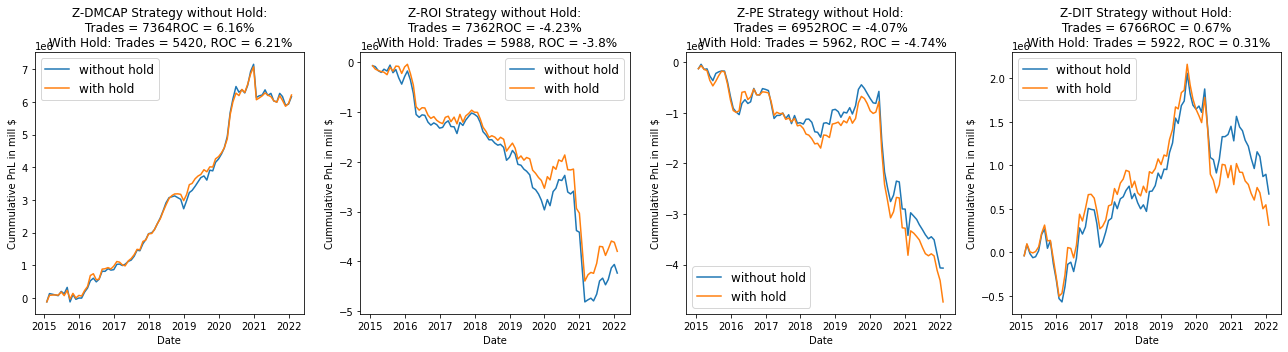

In [1494]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
i=0
for z in df_final.columns[-4:]:
    tr1, t1 = trade_execution(0.08,z,0.1)
    tr2, t2 = trade_execution(0.08,z,0.1,.2)
    shortProfit = tr1.ShortPnL.sum()
    longProfit = tr1.LongPnL.sum()
    repoCash = tr1.RepoCash.sum()
    totalProfit = shortProfit + longProfit + repoCash
    roc1 = round(tr1.CumPnL.iloc[-1]/tr1.StartCapital.iloc[0]*100,2)
    roc2 = round(tr2.CumPnL.iloc[-1]/tr2.StartCapital.iloc[0]*100,2)
    ax[i].plot(tr1['ExitDate'],tr1['CumPnL'],label = 'without hold')
    ax[i].plot(tr2['ExitDate'],tr2['CumPnL'],label = 'with hold')
    ax[i].legend(fontsize = 9)
    ax[i].set(xlabel='Date', ylabel='Cummulative PnL in mill $',title =z+ f' Strategy without Hold:\n Trades = {t1}ROC = {roc1}% \n With Hold: Trades = {t2}, ROC = {roc2}%')
    i=i+1
plt.tight_layout()
plt.show()

<b> Observations </b>  
1. For our most profitable strategy, based on Debt-to-market-cap ratio, the impact of introducing buffer window has minimal impact on ROC. But it can be clearly observed the number of trades reduce by approx 1/3rd, which converts to <b> savings in trading cost </b>.
2. For ROI ratio strategy as well, buffer window has proved beneficial by improving the return on capital as well as reducing the number of trades.
3. For both PE and DIT ratio strategies, introducing buffer has had a negative impact on PNL, but it has helped in reducing the trading cost.

<b> 5.4 Quantile Sensitivity</b>

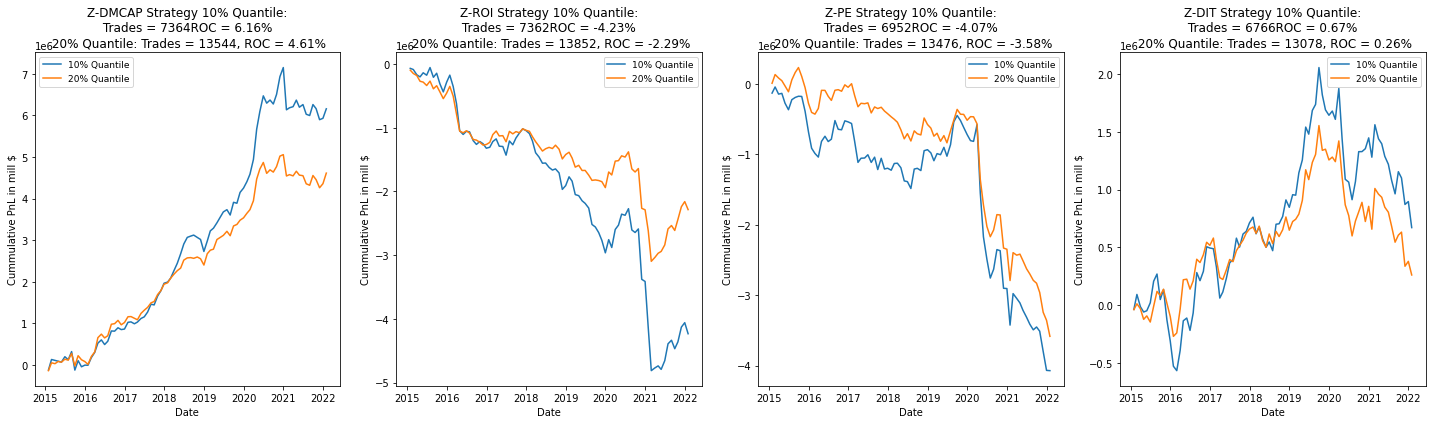

In [1498]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
i=0
for z in df_final.columns[-4:]:
    tr1, t1 = trade_execution(0.08,z,0.1)
    tr2, t2 = trade_execution(0.08,z,0.2)
    roc1 = round(tr1.CumPnL.iloc[-1]/tr1.StartCapital.iloc[0]*100,2)
    roc2 = round(tr2.CumPnL.iloc[-1]/tr2.StartCapital.iloc[0]*100,2)
    ax[i].plot(tr1['ExitDate'],tr1['CumPnL'],label = '10% Quantile')
    ax[i].plot(tr2['ExitDate'],tr2['CumPnL'],label = '20% Quantile')
    ax[i].legend(fontsize = 9)
    ax[i].set(xlabel='Date', ylabel='Cummulative PnL in mill $',title =z+ f' Strategy 10% Quantile:\n Trades = {t1}ROC = {roc1}% \n 20% Quantile: Trades = {t2}, ROC = {roc2}%')
    i=i+1
plt.tight_layout()
plt.show()

<b> Observations </b>  
1. As seen from the graph for both Debt-to-market-cap ratio and Debt-to-income strategy, doubling the quantile percent has reduced the profitablity of the strategy by both, reducing the return on investment as well as increasing the trading cost.
2. Interestingly, doubling the quantile % has helped both ROI and PE strategies in improving their return on capital, but at the expense of increased trading costs. 
3. Overall, on can clearly observe that increasing quantile increases number of trades, but nothing can be concluded about the return.

<b> 5.5 Weighted Z-score </b>

In this sensitivity analysis, we consider the combined power of all 4 financial ratios in generating profitable quantile trading strategy. For simplicity, we assume all 4 are equally weighted, when constructing a new factor. 

In [1499]:
df_final['ZCOMBO']=(df_final['Z-DMCAP']+df_final['Z-ROI']+df_final['Z-PE']+df_final['Z-DIT'])/4

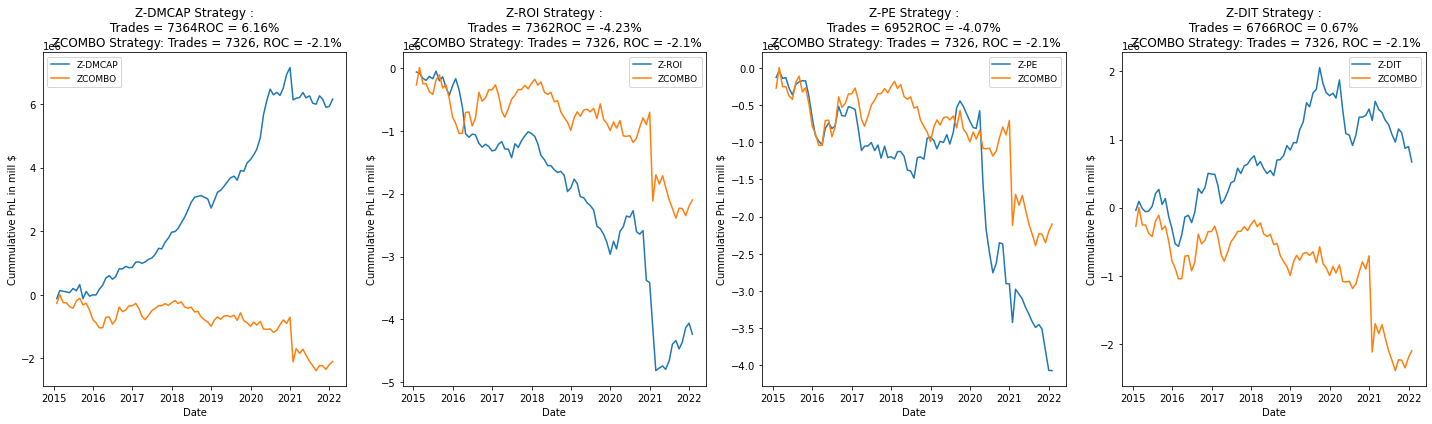

In [1501]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
i=0
for z in df_final.columns[-5:-1]:
    tr1, t1 = trade_execution(0.08,z,0.1)
    tr2, t2 = trade_execution(0.08,'ZCOMBO',0.1)
    roc1 = round(tr1.CumPnL.iloc[-1]/tr1.StartCapital.iloc[0]*100,2)
    roc2 = round(tr2.CumPnL.iloc[-1]/tr2.StartCapital.iloc[0]*100,2)
    ax[i].plot(tr1['ExitDate'],tr1['CumPnL'],label = f'{z}')
    ax[i].plot(tr2['ExitDate'],tr2['CumPnL'],label = 'ZCOMBO')
    ax[i].legend(fontsize = 9)
    ax[i].set(xlabel='Date', ylabel='Cummulative PnL in mill $',title =z+ f' Strategy :\n Trades = {t1}ROC = {roc1}% \n ZCOMBO Strategy: Trades = {t2}, ROC = {roc2}%')
    i=i+1
plt.tight_layout()
plt.show()

<b> Observations </b>  
As seen from all 4 graphs, ZCOMBO ratio strategy sits right in the middle of all the strategy returns, but remains on the higher side for number of trades.

<b> 5.6 Factor Correlation </b>

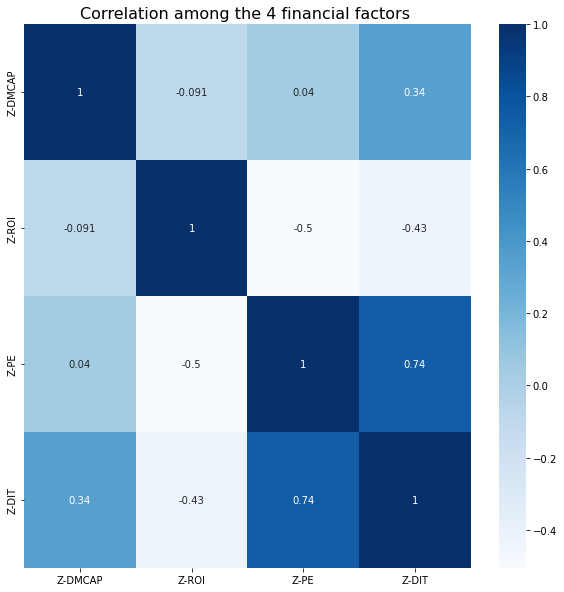

In [1505]:
sns.heatmap(df_final[['Z-DMCAP','Z-ROI','Z-PE','Z-DIT']].corr(),annot=True,cmap='Blues')
plt.title("Correlation among the 4 financial factors ", fontsize = 16)
plt.show()

<b> Observations </b>  
As seen from the heat-graph, correlations between Price-to-Earnings and Debt-to-income is highest of all the correlations. And the correlation between Return on investment and Debt-to-income is lowest(negative). 

# 6. Conclusion

Following is a breif summary of observations and conclusions from the trading strategy simulation and analysis:


- The construction of Quantamental model requires parsing through vast financial data available in repositories for 10K and 8K and isolating relevant information to construct accurate the financial ratios. 
- We need to standardize the financial ratios to make comparision for ratios from companies from various sectors.
- Using LIBOR for short position reduces overall return, but not in a substantial way.
- Buffer window definitly reduces the number of trades and also improves return on capital in some cases.
- Increasing quantile percentage definitly increases number of trades, but may also improve the return on capital.
- After analyzing four strategies in greater detail and identifying the impact of changing parameters in Quantile model on the PnL, we found that Debt-to-MCAP ratio proved most promising in such type of strategies.